In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix

In [3]:
pd.set_option('display.max_columns', None) #so the maximum number of columns are displayed in .head()

In [4]:
#Loading the dataset on a datafdrame data
data = pd.read_csv("Android_Malware.csv")

C:\Users\Devansh\AppData\Local\Temp\ipykernel_1544\2565550375.py:2: DtypeWarning: Columns (56,58,63) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Android_Malware.csv")


In [5]:
data.columns = [i.strip() for i in data.columns] # stripping all the whitespaces from the column names

In [6]:
print(data.isnull().sum())
data = data.dropna()

Unnamed: 0        0
Flow ID           1
Source IP         0
Source Port       0
Destination IP    0
                 ..
Idle Mean         4
Idle Std          4
Idle Max          4
Idle Min          4
Label             0
Length: 86, dtype: int64


In [7]:
#Dropping Android_Adware and Android_Scareware
data['Label'].unique()
labels_to_remove = ['Android_Adware', 'Android_Scareware']
data = data[~data['Label'].isin(labels_to_remove)]
for column in data.columns:
    if 'Timestamp' in column:
        data = data.drop(column, axis = 1)

In [8]:
for column in data.columns:
    if len(data[column].unique()) > 1:
        count = 0
        if str(data[column].unique()[0]) != str(data[column].unique()[1]):
                count += 1
        if (count == 0):
            print('Same Unique Values : ',column)
            data = data.drop(column, axis = 1)
    elif len(data[column].unique()) == 1:
        print('Only 1 value : ', column)
        data = data.drop(column, axis = 1)

Only 1 value :  Bwd PSH Flags
Only 1 value :  Fwd URG Flags
Only 1 value :  Bwd URG Flags
Only 1 value :  RST Flag Count
Same Unique Values :  CWE Flag Count
Only 1 value :  ECE Flag Count
Same Unique Values :  Fwd Avg Bytes/Bulk
Only 1 value :  Fwd Avg Packets/Bulk
Only 1 value :  Fwd Avg Bulk Rate
Only 1 value :  Bwd Avg Bytes/Bulk
Only 1 value :  Bwd Avg Packets/Bulk
Only 1 value :  Bwd Avg Bulk Rate


In [9]:
data['Down/Up Ratio']  = [float(x) for x in data['Down/Up Ratio'].values]

In [10]:
data.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
264525,0,10.42.0.151-40.69.219.199-35131-443-6,10.42.0.151,35131,40.69.219.199,443.0,6.0,12109,2,0,85.0,0.0,85.0,0.0,42.500000,60.104076,0.0,0.0,0.000000,0.000000,7019.572219,165.166405,12109.000000,0.000000,12109.0,12109.0,12109.0,12109.0,0.000000,12109.0,12109.0,0.0,0.0,0.000000,0.0,0.0,1.0,64,0,165.166405,0.000000,0.0,85.0,56.666667,49.074773,2408.333333,0.0,1.0,0.0,1.0,0.0,0.0,85.000000,42.500000,0.000000,64.0,2.0,85.0,0.0,0.0,1550.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
264526,1,10.42.0.151-40.69.219.199-35131-443-6,40.69.219.199,443,10.42.0.151,35131.0,6.0,43,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,46511.627907,43.000000,0.000000,43.0,43.0,43.0,43.0,0.000000,43.0,43.0,0.0,0.0,0.000000,0.0,0.0,0.0,64,0,46511.627907,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,64.0,2.0,0.0,0.0,0.0,510.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
264527,2,10.42.0.151-40.122.44.96-54930-443-6,10.42.0.151,54930,40.122.44.96,443.0,6.0,14678,2,0,85.0,0.0,85.0,0.0,42.500000,60.104076,0.0,0.0,0.000000,0.000000,5790.979698,136.258346,14678.000000,0.000000,14678.0,14678.0,14678.0,14678.0,0.000000,14678.0,14678.0,0.0,0.0,0.000000,0.0,0.0,1.0,64,0,136.258346,0.000000,0.0,85.0,56.666667,49.074773,2408.333333,0.0,1.0,0.0,1.0,0.0,0.0,85.000000,42.500000,0.000000,64.0,2.0,85.0,0.0,0.0,1550.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
264528,3,10.42.0.151-40.122.44.96-54930-443-6,40.122.44.96,443,10.42.0.151,54930.0,6.0,43,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,46511.627907,43.000000,0.000000,43.0,43.0,43.0,43.0,0.000000,43.0,43.0,0.0,0.0,0.000000,0.0,0.0,0.0,64,0,46511.627907,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,64.0,2.0,0.0,0.0,0.0,509.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
264529,4,10.42.0.151-52.179.153.195-53215-443-6,10.42.0.151,53215,52.179.153.195,443.0,6.0,3355709,11,7,1290.0,5430.0,869.0,0.0,117.272727,263.158542,1448.0,0.0,775.714286,672.413245,2002.557433,5.363993,197394.647059,653868.357763,2731778.0,6.0,3355709.0,335570.9,843621.265168,2731778.0,13.0,542766.0,90461.0,100811.101629,200127.0,6.0,0.0,360,232,3.277996,2.085997,0.0,1448.0,353.684211,547.317403,299556.339181,0.0,0.0,1.0,0.0,0.0,0.0,373.333333,117.272727,775.714286,360.0,11.0,1290.0,7.0,5430.0,65535.0,510.0,3.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware


In [11]:
from category_encoders import TargetEncoder

In [12]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [13]:
x = data.drop(['Label'], axis=1)
y = [data['Label'].unique().tolist().index(i) for i in data['Label']]

In [16]:
print(data['Label'].unique())

['Android_SMS_Malware' 'Benign']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [14]:
# Apply target encoding only to training data
encoder = TargetEncoder()
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train, y_train), columns=X_train.columns)
X_test_encoded = pd.DataFrame(encoder.transform(X_test), columns=X_test.columns)

In [15]:
# Apply scaling only to training data
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  10.5s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  10.8s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  10.7s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  10.3s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  10.1s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=5; total time=  12.1s
[CV] END classifier__max_depth=40,

[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=5; total time=   0.1s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=

[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   2.0s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   2.1s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   2.0s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   2.0s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classi

[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.6s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.6s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.6s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=200, classifier__subsample=0.8; total time=   1.3s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0, classifier__learning_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   9.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   9.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   9.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   9.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   6.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   6.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   7.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   7.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   7.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   9.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   9.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   9.3s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   3.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   3.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   3.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   6.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   6.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   6.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   6.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   6.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   6.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   7.1s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   2.6s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   2.7s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   2.7s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   2.5s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   2.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.8s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.9s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.9s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.9s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.9s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best parameters for lr: {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__l1_ratio': 0.1, 'classifier__C': 0.1}
Classification report for lr:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     20218
           1       0.98      0.57      0.72      7113

    accuracy                           0.89     27331
   macro avg       0.93      0.78      0.83     27331
weighted avg       0.90      0.89      0.87     27331

Confusion Matrix for lr:
[[20156    62]
 [ 3057  4056]]

AUC for lr: 0.96



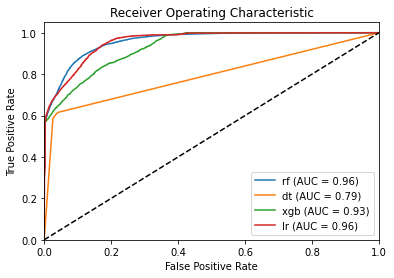

In [16]:
# Setting up the pipelines for each classifier
pipelines = {
    'rf': Pipeline([('classifier', RandomForestClassifier(random_state=42))]),
    'dt': Pipeline([('classifier', DecisionTreeClassifier(random_state=42))]),
    'xgb': Pipeline([('classifier', XGBClassifier(random_state=42))]),
    'lr': Pipeline([('classifier', LogisticRegression(random_state=42))])
}

# Hyperparameter space for each classifier
param_distributions = {
    'rf': {
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2']
    },
    'dt': {
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2']
    },
    'xgb': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__min_child_weight': [1, 3, 5],
        'classifier__gamma': [0, 0.1, 0.2, 0.5],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0]
    },
       'lr': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': [0.1, 0.5, 0.7, 1]  # This is only used if penalty is 'elasticnet'
    }

}

best_estimators = {}
roc_auc_scores = {}
plt.figure()
for model_name, pipeline in pipelines.items():
    search = RandomizedSearchCV(pipeline, param_distributions[model_name], n_iter=10, cv=5, verbose=2, random_state=42)
    search.fit(X_train_scaled, y_train)
    best_estimators[model_name] = search.best_estimator_
    print(f"Best parameters for {model_name}: {search.best_params_}")
    
    # Predict probabilities for the test data
    y_probs = search.predict_proba(X_test_scaled)[:, 1]
    y_pred = search.predict(X_test_scaled)
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[model_name] = roc_auc
    
     # Aggregate ROC curve data for each model
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    # Print Classification Report
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")
    # Print Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {model_name}:\n{cm}\n")
    
    # Print AUC
    print(f"AUC for {model_name}: {roc_auc:.2f}\n")
    # Finalizing the ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Applying SMOTE 

In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [19]:
from collections import Counter

# Count the occurrences of each class in y_train_smote
class_counts = Counter(y_train_smote)
print(class_counts)


Counter({0: 47176, 1: 47176})


## Feature Selection

In [20]:
random_search_selected_features = ['Flow IAT Mean', 'Average Packet Size', 'Subflow Bwd Bytes', 'Flow ID', 'Fwd Packet Length Mean', 'Bwd IAT Mean', 'Total Length of Fwd Packets', 'Down/Up Ratio', 'Bwd Packet Length Max', 'Flow Duration', 'Min Packet Length', 'Destination Port', 'Packet Length Mean', 'Bwd IAT Min', 'Fwd Packet Length Min', 'Source IP', 'Fwd Packet Length Std', 'Flow IAT Std', 'Bwd IAT Total', 'Idle Min', 'Flow Packets/s', 'Active Std']
simulated_annealing_selected_features = ['Active Std', 'Packet Length Mean', 'Avg Bwd Segment Size', 'Subflow Bwd Packets', 'Total Fwd Packets', 'Idle Min', 'Average Packet Size', 'Subflow Bwd Bytes', 'Fwd Packet Length Mean', 'min_seg_size_forward', 'Idle Std', 'Fwd IAT Mean', 'Init_Win_bytes_backward', 'Bwd IAT Min', 'Fwd Packet Length Std', 'Active Max', 'Fwd Packet Length Min', 'act_data_pkt_fwd', 'Fwd IAT Std', 'Avg Fwd Segment Size', 'Source Port', 'Bwd IAT Total', 'Bwd Packet Length Std', 'Max Packet Length', 'Fwd Packet Length Max', 'Source IP', 'Fwd IAT Max', 'Flow IAT Std', 'Bwd Packets/s', 'Destination IP', 'Protocol', 'Total Backward Packets', 'Packet Length Std', 'Active Mean', 'Min Packet Length', 'Destination Port', 'URG Flag Count', 'Total Length of Bwd Packets', 'SYN Flag Count', 'PSH Flag Count', 'Bwd IAT Mean', 'Bwd Header Length', 'Fwd Header Length', 'Total Length of Fwd Packets', 'Down/Up Ratio', 'Bwd IAT Std', 'Flow Bytes/s', 'Fwd Header Length.1', 'Fwd IAT Min', 'Idle Max', 'Fwd IAT Total', 'Flow Duration', 'Idle Mean', 'Fwd PSH Flags']
genetic_search_selected_features = [
    'Source Port', 'min_seg_size_forward', 'Min Packet Length', 'Bwd Packet Length Std',
    'Bwd IAT Mean', 'Fwd Packets/s', 'Bwd Packets/s', 'Total Length of Bwd Packets',
    'Avg Bwd Segment Size', 'Init_Win_bytes_backward', 'Fwd IAT Max', 'Bwd IAT Max',
    'Fwd Header Length.1', 'Protocol', 'Total Length of Fwd Packets', 'URG Flag Count',
    'Fwd Packet Length Mean', 'Init_Win_bytes_forward', 'Bwd Packet Length Min',
    'Fwd IAT Mean', 'Flow Bytes/s', 'Down/Up Ratio', 'Active Std', 'Avg Fwd Segment Size',
    'Fwd IAT Total', 'Fwd Packet Length Std', 'Subflow Bwd Packets', 'Flow ID',
    'Fwd Packet Length Max', 'Bwd IAT Min', 'Idle Min', 'Flow IAT Mean', 'Subflow Bwd Bytes',
    'Bwd Packet Length Mean', 'Destination Port', 'Average Packet Size', 'Source IP',
    'Active Min', 'Flow IAT Min', 'Fwd Packet Length Min', 'Total Fwd Packets', 'Flow Packets/s',
    'Fwd Header Length', 'Packet Length Variance', 'Bwd IAT Std', 'Subflow Fwd Packets'
]



In [21]:
def run_models(X_train, X_test, y_train, y_test, feature_set_name):
    # Update X_train and X_test to include only the selected features
    X_train_selected = X_train_smote[feature_set_name]
    X_test_selected = X_test_scaled[feature_set_name]


    best_estimators = {}
    roc_auc_scores = {}
    plt.figure()
    for model_name, pipeline in pipelines.items():
        search = RandomizedSearchCV(pipeline, param_distributions[model_name], n_iter=10, cv=5, verbose=2, random_state=42)
        search.fit(X_train_selected, y_train)
        best_estimators[model_name] = search.best_estimator_
        print(f"Best parameters for {model_name}: {search.best_params_}")
        
        # Predict probabilities for the test data
        y_probs = search.predict_proba(X_test_selected)[:, 1]
        y_pred = search.predict(X_test_selected)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        roc_auc_scores[model_name] = roc_auc
        
         # Aggregate ROC curve data for each model
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        
        # Print Classification Report
        print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")

        # Print Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix for {model_name}:\n{cm}\n")
        
        # Print AUC
        print(f"AUC for {model_name}: {roc_auc:.2f}\n")
    # Finalizing the ROC plot
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    

Evaluating Random Search Selected Features
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   9.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   8.9s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   8.8s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   9.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   9.1s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=5; total time

[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=5; total time=   0.1s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=

[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   1.0s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   0.9s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   1.0s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   1.0s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classi

[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.8s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.8s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.9s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=200, classifier__subsample=0.8; total time=   2.0s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0, classifier__learning_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   6.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   6.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   6.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   6.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   6.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   5.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   5.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   5.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   5.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   5.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   5.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   6.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   5.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   5.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   6.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   5.9s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   0.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   5.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   5.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   5.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   5.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   5.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   5.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   5.1s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.6s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.6s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.6s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.6s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.6s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.5s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.7s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.6s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters for lr: {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__l1_ratio': 1, 'classifier__C': 10}
Classification report for lr:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     20218
           1       0.96      0.58      0.73      7113

    accuracy                           0.89     27331
   macro avg       0.92      0.79      0.83     27331
weighted avg       0.90      0.89      0.88     27331

Confusion Matrix for lr:
[[20063   155]
 [ 2970  4143]]

AUC for lr: 0.94



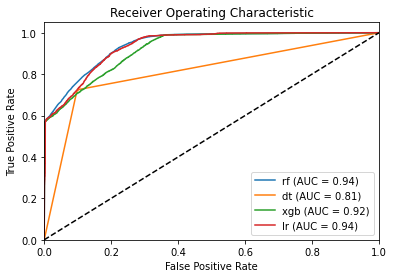

In [22]:
print("Evaluating Random Search Selected Features")
run_models(X_train_smote, X_test, y_train_smote, y_test, random_search_selected_features)

Evaluating Simulated Annealing Selected Features
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  22.4s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  22.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  21.4s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  22.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  21.8s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=5; tota

[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.3s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.3s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.3s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.2s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.3s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=5; total time=   0.4s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=

[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   3.5s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   3.6s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   3.7s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   3.8s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classi

[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   1.5s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   1.5s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   1.5s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=200, classifier__subsample=0.8; total time=   2.5s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0, classifier__learning_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=  12.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=  11.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=  11.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=  11.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=  11.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   9.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   9.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   8.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=  11.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=  11.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=  11.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=  11.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=  11.2s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   2.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   2.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   3.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   9.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   9.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   9.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   9.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   8.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   8.8s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   1.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   1.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   1.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   1.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   1.4s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.5s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.2s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.4s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.3s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.3s
Best parameters for lr: {'classifier__solver': 'saga', 'classifier__penalty': 'elasticnet', 'classifier__l1_ratio': 0.7, 'classifier__C': 0.1}
Classification report for lr:
              precision    recall  f1-score

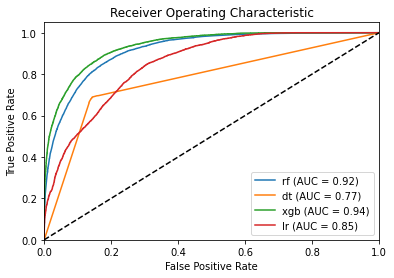

In [23]:
print("Evaluating Simulated Annealing Selected Features")
run_models(X_train_smote, X_test, y_train_smote, y_test, simulated_annealing_selected_features)

Evaluating Genetic Search Selected Features
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  13.4s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  12.6s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  12.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  12.8s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=  12.3s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=5; total tim

[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.2s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.1s
[CV] END classifier__max_depth=50, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=10; total time=   0.2s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=5; total time=   0.2s
[CV] END classifier__max_depth=40, classifier__max_features=auto, classifier__min_samples_leaf=

[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   1.9s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   1.9s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   2.0s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__min_child_weight=5, classifier__n_estimators=150, classifier__subsample=1.0; total time=   2.0s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classi

[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   1.0s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   1.0s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=50, classifier__subsample=0.8; total time=   1.0s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=200, classifier__subsample=0.8; total time=   2.3s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0, classifier__learning_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=  11.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=  10.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=  10.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=  10.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   9.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   8.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   8.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   8.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   7.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=l2, classifier__solver=saga; total time=   7.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   7.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   7.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   7.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   7.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.7, classifier__penalty=l2, classifier__solver=saga; total time=   8.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=  10.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=  10.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=  10.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=  10.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=100, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga; total time=   9.8s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   1.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   1.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   1.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   1.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   1.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   7.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   7.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   7.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   7.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=1, classifier__penalty=none, classifier__solver=saga; total time=   8.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   8.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   8.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   8.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   8.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=   8.0s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.6s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.7s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.6s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.6s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   1.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.001, classifier__l1_ratio=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.7s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.8s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.7, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters for lr: {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__l1_ratio': 1, 'classifier__C': 10}
Classification report for lr:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     20218
           1       0.96      0.58      0.73      7113

    accuracy                           0.89     27331
   macro avg       0.92      0.79      0.83     27331
weighted avg       0.90      0.89      0.88     27331

Confusion Matrix for lr:
[[20063   155]
 [ 2968  4145]]

AUC for lr: 0.94



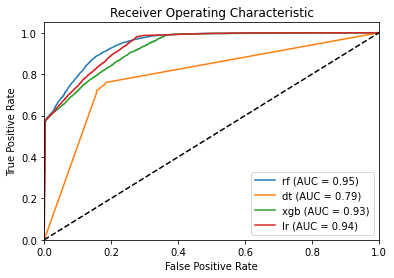

In [24]:
print("Evaluating Genetic Search Selected Features")
run_models(X_train_smote, X_test, y_train_smote, y_test, genetic_search_selected_features)